<a href="https://colab.research.google.com/github/VenGr0/Time_Series_Analysis/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%9623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подготовка данных для решения ДЗ

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Построение моделей нейронных сетей
from keras.models import Sequential, Model

# Слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector

# Оптимизаторы
from keras.optimizers import Adam

# Генератор выборки временных рядов
from keras.preprocessing.sequence import TimeseriesGenerator

# Нормировка
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Отключение лишних предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# импортируем файл с данными о котировках акций Apple
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

# Загрузим только необходимые колонки usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Volume', 'Date'], parse_dates=['Date'])
price.head()

--2024-07-22 15:36:30--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>] 182.17K   206KB/s    in 0.9s    

2024-07-22 15:36:32 (206 KB/s) - ‘AAPL.csv’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


In [ ]:
# Простая последовательность
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# параметры генератора
n_input = 3
batch_size = 1

generator = TimeseriesGenerator(series, series, length=n_input, batch_size=batch_size)

# Число сгенерированных примеров
print('Число примеров: %d' % len(generator))

# Вывод для каждого примера
for i in range(len(generator)):
	x, y = generator[i]

	print('%s => %s' % (x, y))

Число примеров: 7
[[1 2 3]] => [4]
[[2 3 4]] => [5]
[[3 4 5]] => [6]
[[4 5 6]] => [7]
[[5 6 7]] => [8]
[[6 7 8]] => [9]
[[7 8 9]] => [10]


In [ ]:
price.drop(columns=['Volume'], inplace=True)

In [ ]:
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
# Проверка формы данных
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2272, 1)
Тестовые данные: (299, 1)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator


n_input = 14  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 1 # Размер пакета

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: (1, 14, 1), y: (1, 1)


In [ ]:
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')

Форма валидационного пакета: (1, 14, 1), y: (1, 1)


In [ ]:
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма тестовой выборки: (285, 14, 1), y: (285, 1)


In [ ]:
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, title=''):
    fig = plt.figure(figsize=(14, 7))  # Добавлено определение fig
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled



# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов

def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=generator[0][0].shape[1:]))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(n_features))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10921 (42.66 KB)
Trainable params: 10921 (42.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator, validation_data=validator, epochs=20)

Epoch 1/20
2258/2258 [==============================] - 54s 22ms/step - loss: 0.0032 - val_loss: 5.2923e-04
Epoch 2/20
2258/2258 [==============================] - 48s 21ms/step - loss: 4.2372e-04 - val_loss: 8.5955e-04
Epoch 3/20
2258/2258 [==============================] - 48s 21ms/step - loss: 3.6751e-04 - val_loss: 6.6088e-04
Epoch 4/20
2258/2258 [==============================] - 46s 20ms/step - loss: 2.9702e-04 - val_loss: 0.0015
Epoch 5/20
2258/2258 [==============================] - 47s 21ms/step - loss: 2.5545e-04 - val_loss: 2.5845e-04
Epoch 6/20
2258/2258 [==============================] - 45s 20ms/step - loss: 2.5144e-04 - val_loss: 5.6341e-04
Epoch 7/20
2258/2258 [==============================] - 46s 20ms/step - loss: 2.1255e-04 - val_loss: 4.3852e-04
Epoch 8/20
2258/2258 [==============================] - 44s 19ms/step - loss: 2.1710e-04 - val_loss: 2.0807e-04
Epoch 9/20
2258/2258 [==============================] - 46s 20ms/step - loss: 2.0702e-04 - val_loss: 9.1476e-04


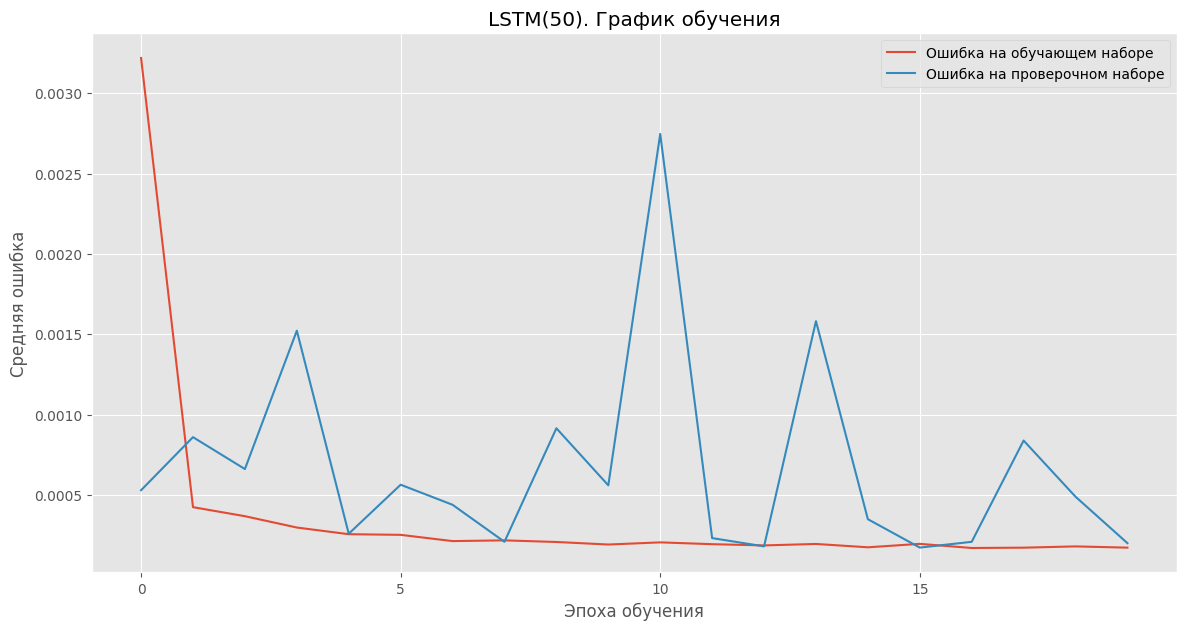

In [ ]:
history_plot(lstm_model.history, 'LSTM(50)')

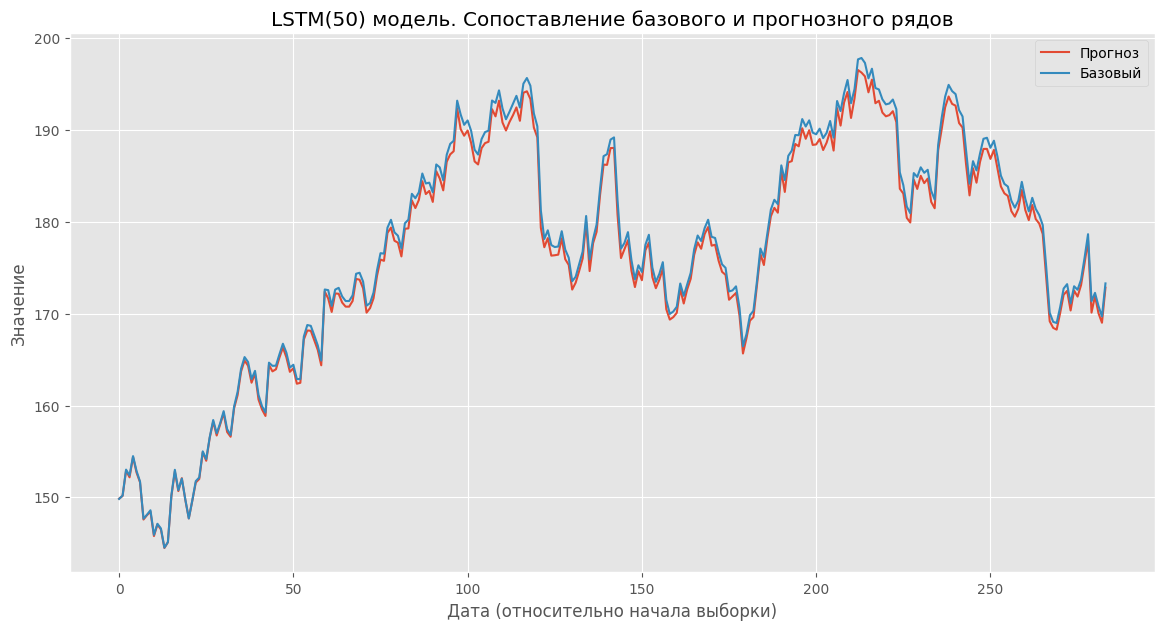

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(lstm_model, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'LSTM(50) модель. Сопоставление базового и прогнозного рядов')

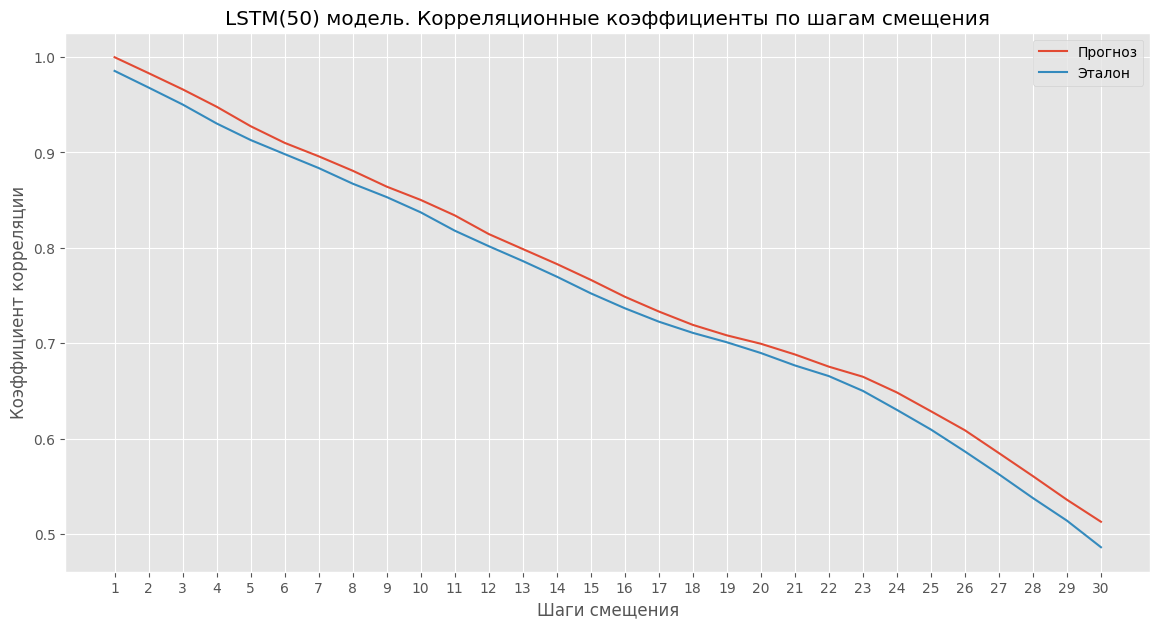

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'LSTM(50) модель. Корреляционные коэффициенты по шагам смещения')

Решение ДЗ

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Параметры генератора
n_input = 14
n_features = 1
BATCH_SIZE = 1  # Изменяем размер батча

# Генератор для обучающих данных
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)

# Генератор для валидационных данных
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)

# Генератор для тестовых данных
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]

# Создание и компиляция модели
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(n_features))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Определение коллбэка для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    'best_lstm_model.h5',  # Путь для сохранения лучшей модели
    monitor='val_loss',    # Мониторинг ошибки на проверочном наборе данных
    save_best_only=True,   # Сохранять только лучшую модель
    mode='min',            # Минимизировать ошибку
    verbose=1              # Вывод информации о процессе сохранения
)

# Обучение модели
history = lstm_model.fit(
    generator,
    validation_data=validator,
    epochs=20,
    callbacks=[checkpoint_callback]  # Добавление коллбэка в процесс обучения
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10921 (42.66 KB)
Trainable params: 10921 (42.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2258/2258 [==============================] - ETA: 0s - loss: 0.0026
Epoch 1: val_loss improved from inf to 0.00056, saving model to best_lstm_model.h5
2258/2258 [==============================] - 51s 22ms/step - loss: 0.0026 - val_loss: 5.6342e-04
Epoch 2/20
2258/2258 [=

In [ ]:
# Объявление функции графика обучения
def history_plot(history, title):
    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов
def show_predict(y_pred, y_true, title=''):
    fig = plt.figure(figsize=(14, 7))  # Добавлено определение fig
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, x_test, y_test, y_scaler):
    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

# Функция рисования корреляций прогнозного ряда и исходного со смещением
def show_corr(y_pred, y_true, title='', break_step=30):
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

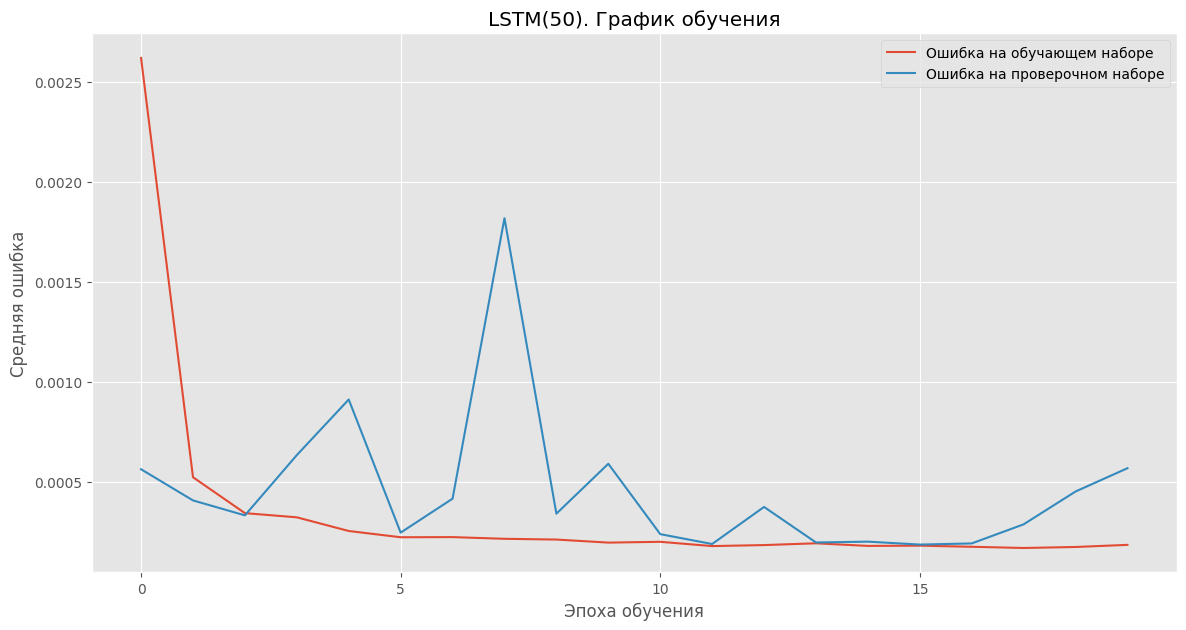

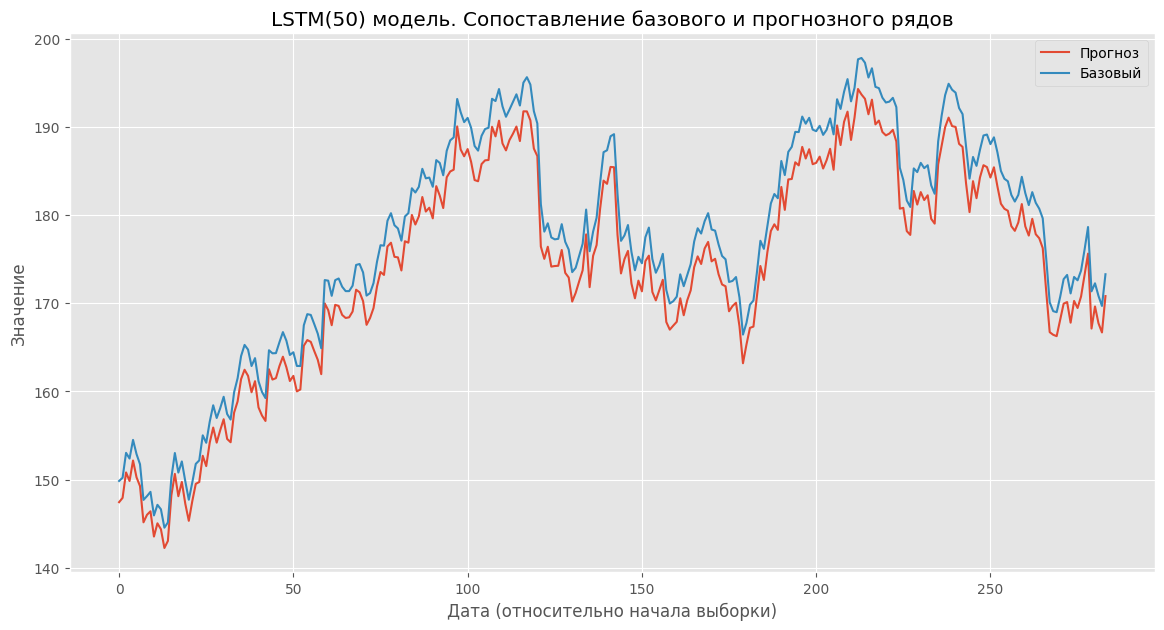

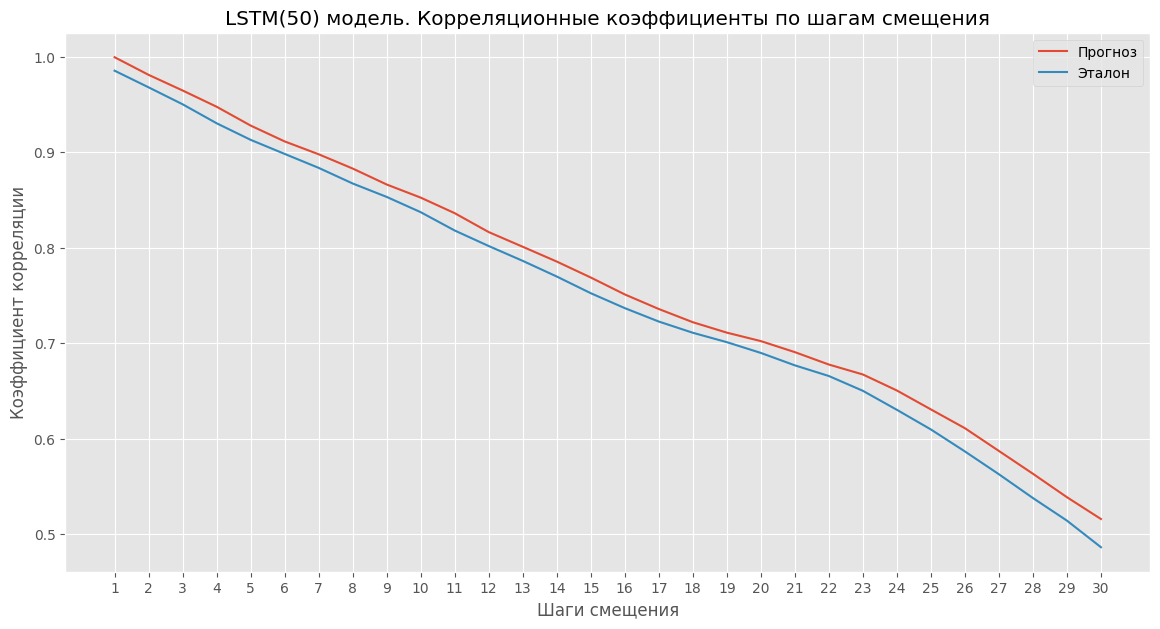

In [ ]:
# Отрисовка графика обучения
history_plot(history, 'LSTM(50)')

# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(lstm_model, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'LSTM(50) модель. Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'LSTM(50) модель. Корреляционные коэффициенты по шагам смещения')

Решение с моделью Conv1D

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Функция для создания и компиляции модели
def create_dense_model(hidden_layers=[100], activation='relu', dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_shape=(n_input, n_features), activation=activation))
    if (dropout_rate > 0):
        model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        if (dropout_rate > 0):
            model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(n_features, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
hidden_layers = [100, 50]
activation = 'relu'  # Функция активации
dropout_rate = 0.5
learning_rate = 0.001  # Скорость обучения

In [ ]:
# Создание и компиляция модели с указанными параметрами
model_dense = create_dense_model(hidden_layers, activation, dropout_rate, learning_rate)
model_dense.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 14, 100)           200       
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 dense_5 (Dense)             (None, 14, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 14, 50)            0         
                                                                 
 flatten (Flatten)           (None, 700)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 701       
                                                                 
Total params: 5951 (23.25 KB)
Trainable params: 5951 (

In [ ]:
# Определение коллбэка для сохранения лучшей модели
checkpoint_callback_dense = ModelCheckpoint(
    'best_dense_model.h5',  # Путь для сохранения лучшей модели
    monitor='val_loss',     # Мониторинг ошибки на проверочном наборе данных
    save_best_only=True,    # Сохранять только лучшую модель
    mode='min',             # Минимизировать ошибку
    verbose=1               # Вывод информации о процессе сохранения
)

# Обучение модели
history_dense = model_dense.fit(
    generator,
    epochs=25,
    validation_data=validator,
    callbacks=[checkpoint_callback_dense]  # Добавление коллбэка в процесс обучения
)

Epoch 1/25
2250/2258 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 1: val_loss improved from inf to 0.01647, saving model to best_dense_model.h5
2258/2258 [==============================] - 12s 5ms/step - loss: 0.0074 - val_loss: 0.0165
Epoch 2/25
2249/2258 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 2: val_loss improved from 0.01647 to 0.00363, saving model to best_dense_model.h5
2258/2258 [==============================] - 11s 5ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 3/25
2258/2258 [==============================] - ETA: 0s - loss: 0.0031
Epoch 3: val_loss did not improve from 0.00363
2258/2258 [==============================] - 10s 4ms/step - loss: 0.0031 - val_loss: 0.0094
Epoch 4/25
2252/2258 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 4: val_loss did not improve from 0.00363
2258/2258 [==============================] - 9s 4ms/step - loss: 0.0036 - val_loss: 0.0235
Epoch 5/25
2248/2258 [============================>

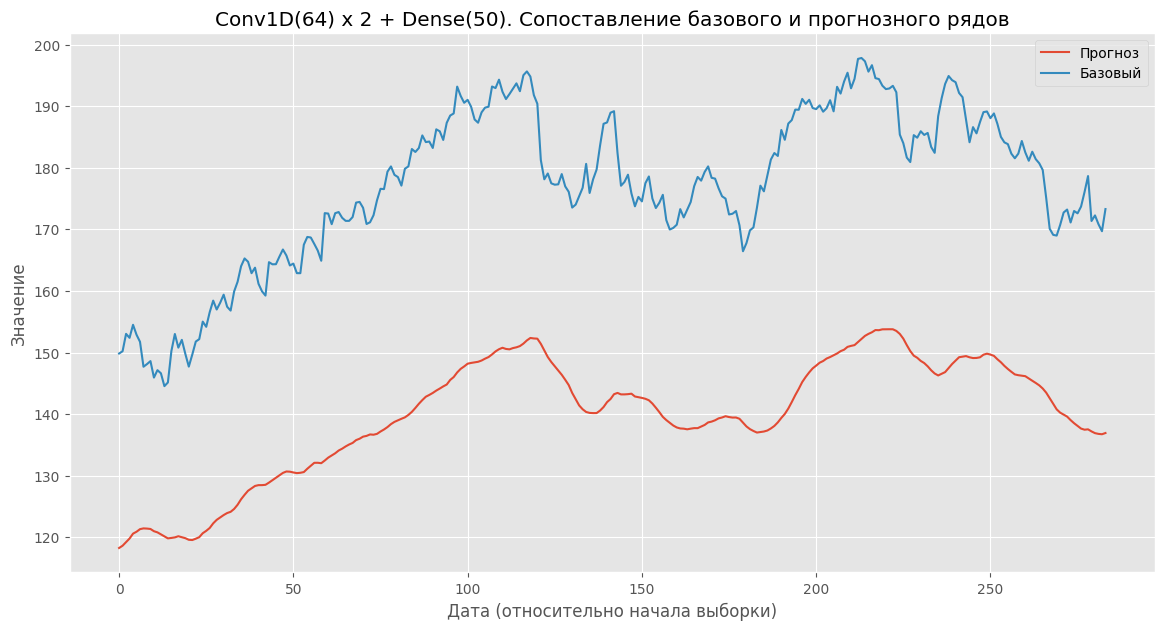

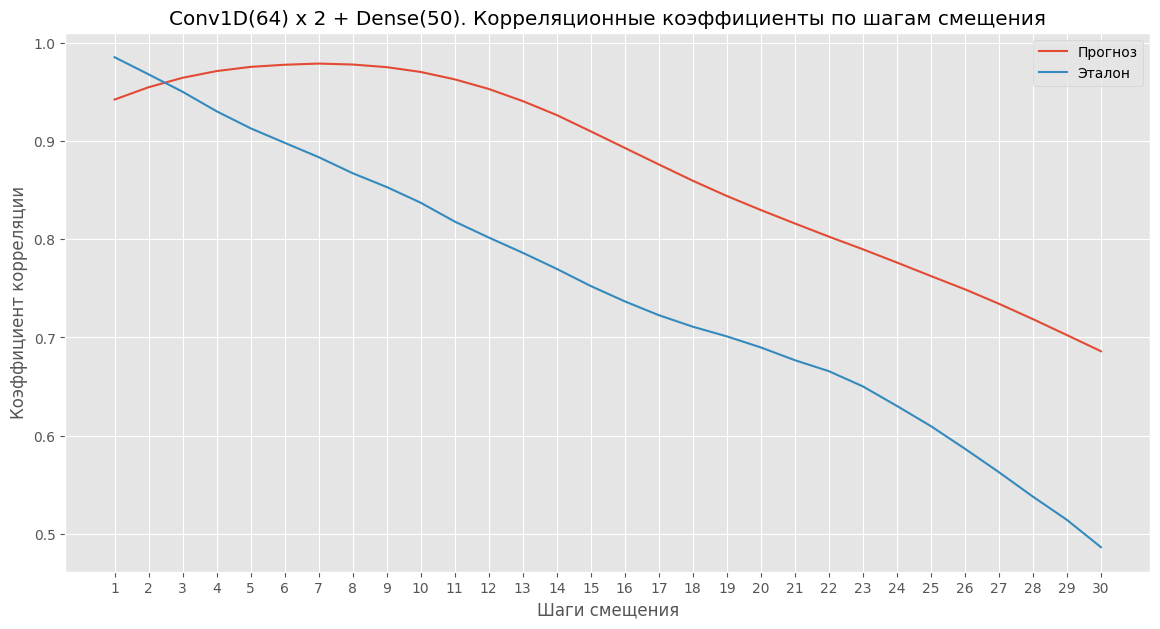

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_dense, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Conv1D(64) х 2 + Dense(50). Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Conv1D(64) х 2 + Dense(50). Корреляционные коэффициенты по шагам смещения')

С добавлением реальных дат

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 14, 100)           200       
                                                                 
 dropout_2 (Dropout)         (None, 14, 100)           0         
                                                                 
 dense_8 (Dense)             (None, 14, 50)            5050      
                                                                 
 dropout_3 (Dropout)         (None, 14, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 700)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 701       
                                                                 
Total params: 5951 (23.25 KB)
Trainable params: 5951 (

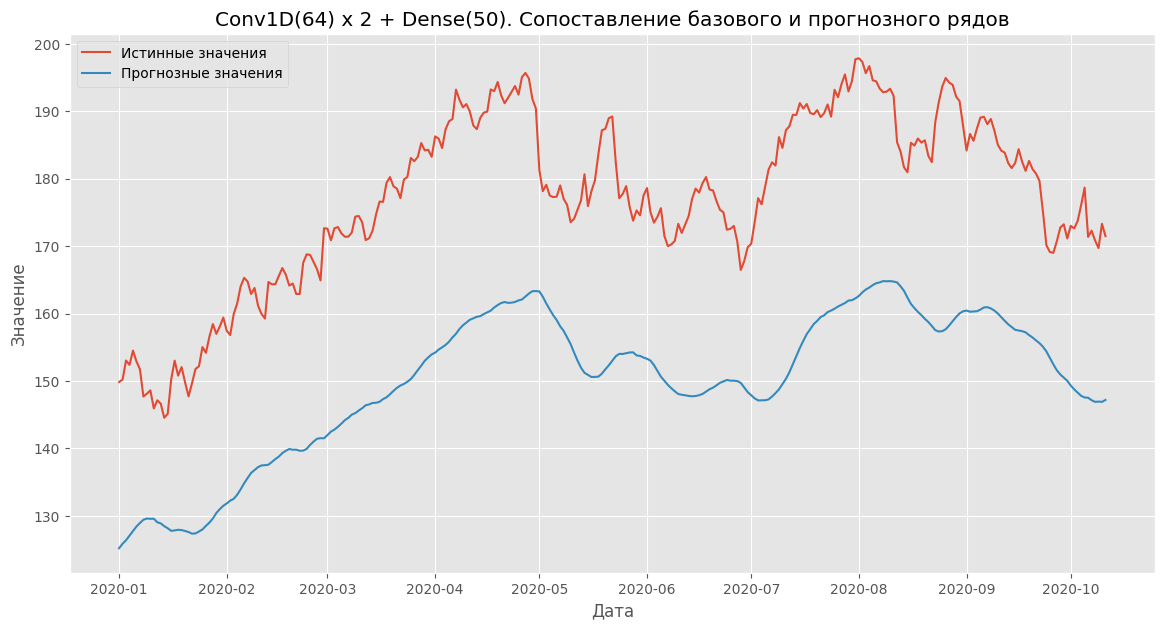

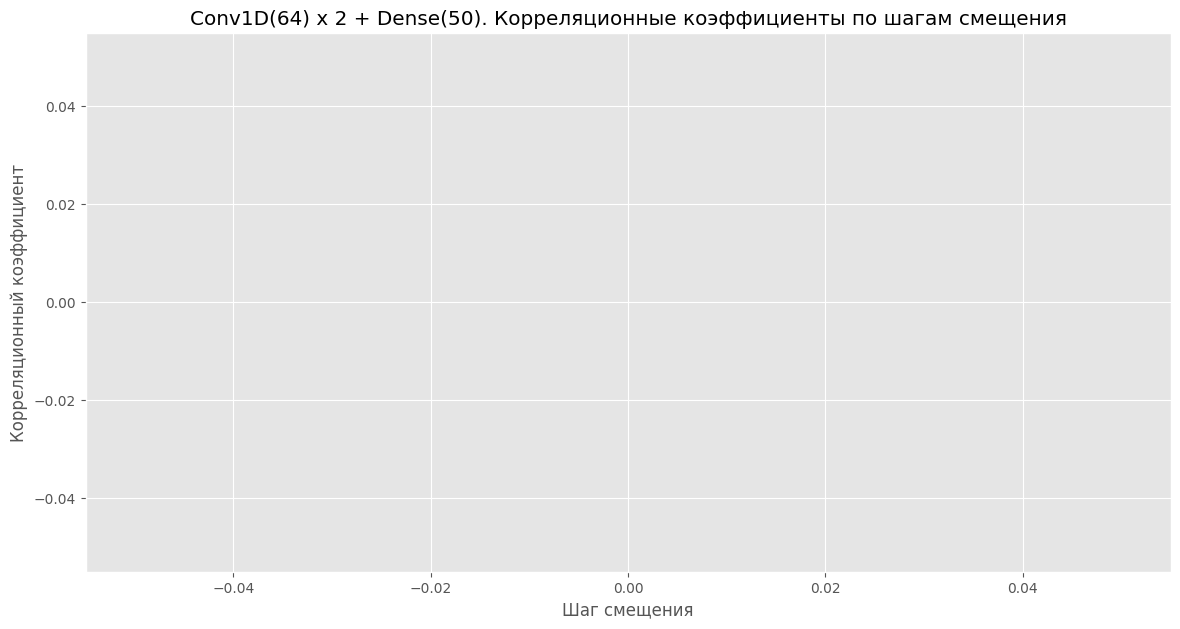

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Функция для создания и компиляции модели
def create_dense_model(hidden_layers=[100], activation='relu', dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_shape=(n_input, n_features), activation=activation))
    if (dropout_rate > 0):
        model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        if (dropout_rate > 0):
            model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(n_features, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

hidden_layers = [100, 50]
activation = 'relu'  # Функция активации
dropout_rate = 0.5
learning_rate = 0.001  # Скорость обучения

# Создание и компиляция модели с указанными параметрами
model_dense = create_dense_model(hidden_layers, activation, dropout_rate, learning_rate)
model_dense.summary()

# Определение коллбэка для сохранения лучшей модели
checkpoint_callback_dense = ModelCheckpoint(
    'best_dense_model.h5',  # Путь для сохранения лучшей модели
    monitor='val_loss',     # Мониторинг ошибки на проверочном наборе данных
    save_best_only=True,    # Сохранять только лучшую модель
    mode='min',             # Минимизировать ошибку
    verbose=1               # Вывод информации о процессе сохранения
)

# Обучение модели
history_dense = model_dense.fit(
    generator,
    epochs=25,
    validation_data=validator,
    callbacks=[checkpoint_callback_dense]  # Добавление коллбэка в процесс обучения
)

# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_dense, x_test, y_test, scaler)

# Предположим, что у вас есть массив дат, соответствующий данным
dates = pd.date_range(start='2020-01-01', periods=len(y_true), freq='D')

# Функция для отрисовки графика с реальными датами
def show_predict_with_dates(y_pred, y_true, dates, title=''):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true, label='Истинные значения')
    plt.plot(dates, y_pred, label='Прогнозные значения')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict_with_dates(y_pred, y_true, dates, title='Conv1D(64) х 2 + Dense(50). Сопоставление базового и прогнозного рядов')

# Функция для отрисовки графика корреляционных коэффициентов
def show_corr(y_pred, y_true, title=''):
    max_lag = min(len(y_pred), 100)  # Максимум 100 шагов смещения
    lags = np.arange(0, max_lag)
    corrs = [np.corrcoef(y_true[:-lag], y_pred[lag:])[0, 1] if lag > 0 else np.corrcoef(y_true, y_pred)[0, 1] for lag in lags]

    plt.figure(figsize=(14, 7))
    plt.plot(lags, corrs)
    plt.xlabel('Шаг смещения')
    plt.ylabel('Корреляционный коэффициент')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title='Conv1D(64) х 2 + Dense(50). Корреляционные коэффициенты по шагам смещения')
